# Constructing an LDA model with spaCy and Gensim

In [1]:
%%capture
!pip install spacy gensim pprint
!python -m spacy download en_core_web_sm
!pip install pyldavis wordcloud bokeh

Initial imports

In [2]:
import pandas as pd
import numpy as np 
from pprint import pprint

import gensim, spacy, logging, warnings
from gensim import corpora
import pyLDAvis

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

We start with importing our data set into a Pandas dataframe

In [3]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [4]:
# lets see a few random posts on this news group
print(df['content'][255], '\ntarget name: ', df['target_names'][255],'\nDataFrame shape: ', df.shape)

From: dmsilev@athena.mit.edu (Daniel M Silevitch)
Subject: Re: Utility for updating Win.ini and system.ini
Organization: Massachusetts Institute of Technology
Lines: 28
Distribution: world
NNTP-Posting-Host: w20-575-72.mit.edu

In article <1993Apr20.180234.18192@oz.plymouth.edu>, oddjob@oz.plymouth.edu (Andrew C. Stoffel) writes:
|> In article <1993Apr20.151912.18590@midway.uchicago.edu> am37@midway.uchicago.edu writes:
|> 
|> >Unless I am completely misunderstanding you, try using either Notepad or
|> >sysedit.exe (found in your system subdirectory) to edit you .ini files.
|> You can add sysedit (& regedit) to a program group... they are Windows
|> programs. 
|> >The sysedit.exe program is cool because it automatically opens you win.ini,
|> >system.ini, autoexec.bat and config.sys files to be edited.
|> 
|> Is it possible to get it to load other *.ini files ????
|> 

No. When the program is run, it loads 4 configuration files; autoexec.bat,
config.sys, win.ini, and system.ini. There i

In [5]:
df.drop(columns=["target"], inplace=True)
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :].reset_index()
print(df.shape)

(2361, 3)


Before starting, we extend the stopword list of the English spaCy model with some domain-specific ones.

In [6]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

nlp.Defaults.stop_words.update(['from', 'subject', 're', 'edu', 'use', 'not', 
                               'would', 'say', 'could', '_', 'be', 'know', 'good', 
                               'go', 'get', 'do', 'done', 'try', 'many', 'some',
                               'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                               'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even',
                               'right', 'line', 'even', 'also', 'may', 'take', 'come'])

First processing round:

*   tokenize
*   filter out the following:


1.   non-alphabetic tokens
2.   too short tokens

1.   too long tokens

 Convert to lowercase tokens














we tokenize, filter out non-alphabetic and too short or long tokens and lowercase.


In [7]:
%%time
MIN_WORD_LEN = 2
MAX_WORD_LEN = 15

def text_to_words(text):
    """Tokenize a text and do some prefiltering for n-gram processing.
    Please take the lowercased form of a token (after spacy analysis of text), 
    if it is not a number (consists of only letters), and it's character length is between the min and the max
    """
    doc = nlp(text)  # Using the model to analyse the text
    token_list=[]  #create a list to store the analysed tokens
    
    #iterate through the tokens in the doc and do the processing
    for token in doc:     
      if token.is_alpha==True and MIN_WORD_LEN<=len(token)<=MAX_WORD_LEN:
        token_list.append(token.text.lower())

    return token_list

texts = df.content.values.tolist()
texts_words = [text_to_words(text) for text in texts]
print(texts_words[:1])

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'what', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'richardson', 'tx', 'dod']]
CP

Merge bi-, tri- and four-gram collocations with Gensim

In [8]:
%%time
# if 2 or 3 words are occuring alot togather concatinate them, else 
# keep single words as it is
from gensim.models.phrases import Phrases
# Build the bigram and trigram models
# The minimum occurency of a bigram phrase should be 5 (2 words should occure atleast 5 times togather to be inclued)
# Both the bigram and trigram phrases should have the threshold 100
bigram_phrases = Phrases(texts_words, min_count=5, threshold=100) #You should operate on text_phrases here
trigram_phrases = Phrases(bigram_phrases[texts_words], min_count=5, threshold=100) # You should use the previously defined bigram_phrases to "look up" text_phrases again

# This is a kind of technical pruning only.
bigram_phraser = gensim.models.phrases.Phraser(bigram_phrases)
trigram_phraser = gensim.models.phrases.Phraser(trigram_phrases)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 10.6 s, sys: 44.7 ms, total: 10.6 s
Wall time: 10.6 s


In [9]:
# Apply the n-gram models to the data
texts_words = [trigram_phraser[bigram_phraser[words]] for words in texts_words]

Having merged the collocations, we do another (final) round of filtering on the basis of stopwords and POS-tags, and lemmatize all tokens.

In [10]:
%%time
# Now we use spacy to filter based on stopwords, POS-tags and lemmatize

filtered_texts_lemmas = []

for words in texts_words:
    doc = spacy.tokens.Doc(nlp.vocab, words=words)
    tagged = nlp.get_pipe("tagger")(doc)
    
    # Please filter again, and keep only the lemma of tokens which are non stopwords and are either 'NOUN', 'ADJ', 'VERB' or 'ADV
    # with regards to their part of speech tags

    allowed_POS_tags = "NOUN", "ADJ", "VERB", "ADV"
    lemma_list=[]
    for token in doc:
      # if its a stopword dont go ahead
      if token.is_stop == False:
        if token.pos_ in allowed_POS_tags:
          # we want lemmas b/c e.g working, work, worked have same meaning and 
          # we dont want all of them.
          lemma_list.append(token.lemma_)
    filtered_texts_lemmas.append(lemma_list)


print(filtered_texts_lemmas[0])

['recommendation', 'duc', 'summary', 'worth', 'expire', 'gmt', 'ducati', 'line', 'ducati', 'model', 'clock', 'run', 'paint', 'bronze', 'orange', 'fade', 'leak', 'bit', 'oil', 'pop', 'hard', 'accel', 'shop', 'fix', 'tran', 'oil', 'leak', 'sell', 'bike', 'owner', 'think', 'opinion', 'email', 'thank', 'stable', 'mate', 'beemer', 'bike', 'motor', 'computrac_richardson_tx']
CPU times: user 28.8 s, sys: 324 ms, total: 29.1 s
Wall time: 29.1 s


Time to build the LDA model!

First i create a dictionary

In [11]:
#%%capture
# Create Dictionary
#create a Gensim dictionary from the final "filtered_texts_lemmas"
# This dictionary will contain unique tokens
id2word = gensim.corpora.dictionary.Dictionary(filtered_texts_lemmas) 

# use a function of the dictionary to filter out the "extremes", meaning: keep only 5000 elements.
# we keep first 5000 most frequent tokens
id2word.filter_extremes(keep_n=5000) 

# print the dictionary
print(id2word)

Dictionary(5000 unique tokens: ['beemer', 'bike', 'bit', 'bronze', 'clock']...)


In [12]:
# Create Corpus: Term Document Frequency
# model wont understand strings so convert them to numbers 
# each token is assigned a unique id (we should have 5000 unique ids)
# we will get a tuple of stuff (unique id of word, occurance of that word in that sentence)
corpus = [id2word.doc2bow(words) for words in filtered_texts_lemmas]
print(corpus)

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)], [(30, 1), (31, 7), (32, 1), (33, 2), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 5), (55, 1)], [(33, 1), (36, 1), (37, 1), (53, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 2), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 3), (78, 2), (79, 1), (80, 1), (81, 1), (82, 2), (83, 2), (84, 2), (85, 1), (86, 2), (87, 1), (88, 2), (89, 1), (90, 2), (91, 1), (92, 2), (93, 1), (94, 3), (95, 1), (96, 2), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1)

In [43]:
# Build LDA model with the corpus, the dictionary mapping and 4 topics! (All other parameters we have given...)
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           num_topics=4,
                                           id2word=id2word, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           iterations=700,
                                           per_word_topics=True)

In [44]:
pprint(lda_model.print_topics())

[(0,
  '0.012*"people" + 0.009*"israeli" + 0.008*"state" + 0.006*"law" + '
  '0.006*"jewish" + 0.006*"government" + 0.005*"armenian" + 0.005*"turkish" + '
  '0.005*"say" + 0.005*"war"'),
 (1,
  '0.024*"team" + 0.021*"game" + 0.014*"play" + 0.012*"year" + 0.012*"player" '
  '+ 0.009*"win" + 0.009*"hockey" + 0.007*"season" + 0.007*"time" + '
  '0.007*"organization"'),
 (2,
  '0.013*"believe" + 0.012*"people" + 0.011*"question" + 0.008*"thing" + '
  '0.008*"church" + 0.007*"reason" + 0.007*"say" + 0.007*"time" + 0.006*"mean" '
  '+ 0.006*"faith"'),
 (3,
  '0.016*"go" + 0.015*"say" + 0.014*"bike" + 0.009*"time" + 0.008*"tell" + '
  '0.008*"people" + 0.008*"ride" + 0.007*"get" + 0.007*"look" + 0.007*"see"')]


# Inference and visualizations

### Dominant topic and its percentage in documents

In [45]:
texts_topics_df = pd.DataFrame()

# Get main topic in each document
for topic_probs, text in zip(lda_model.get_document_topics(corpus), filtered_texts_lemmas):
    topic_num, topic_prob = max(topic_probs, key=lambda x: x[1])
    wp = lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, _ in wp])
    texts_topics_df = texts_topics_df.append(pd.Series([topic_num, round(topic_prob,4), topic_keywords, text]), ignore_index=True)

texts_topics_df.columns = ["topic_no", "topic_ratio", "keywords", "text"]
texts_topics_df["topic_no"]=texts_topics_df.topic_no.astype("int")
texts_topics_df.head(10)

,topic_no,topic_ratio,keywords,text
0,1,0.6311,"team, game, play, year, player, win, hockey, s...","[recommendation, duc, summary, worth, expire, ..."
1,1,0.8239,"team, game, play, year, player, win, hockey, s...","[group, line, article, write, course, time, ca..."
2,2,0.6872,"believe, people, question, thing, church, reas...","[article, write, new, group, maybe, cover, cur..."
3,0,0.7396,"people, israeli, state, law, jewish, governmen...","[nntp_posting_host, reply, amir_rosenblatt, or..."
4,1,0.7180,"team, game, play, year, player, win, hockey, s...","[goalie_mask, organization, solar_terresterial..."
5,1,0.4811,"team, game, play, year, player, win, hockey, s...","[bmw_moa_member, read, organization, national,..."
6,1,0.5568,"team, game, play, year, player, win, hockey, s...","[should_liability_insurance, require, organiza..."
7,3,0.3846,"go, say, bike, time, tell, people, ride, get, ...","[look, movie, university, line, summary, bike,..."
8,2,0.7666,"believe, people, question, thing, church, reas...","[university, line, follow, thread, study, inte..."
9,0,0.7894,"people, israeli, state, law, jewish, governmen...","[uucp_serdar_argic, day, night, round, male, i..."


Topic ratio is telling me that what propotion of words are allocated to 4 topics that i want. 

### Wordcloud of the most important keywords in each topic

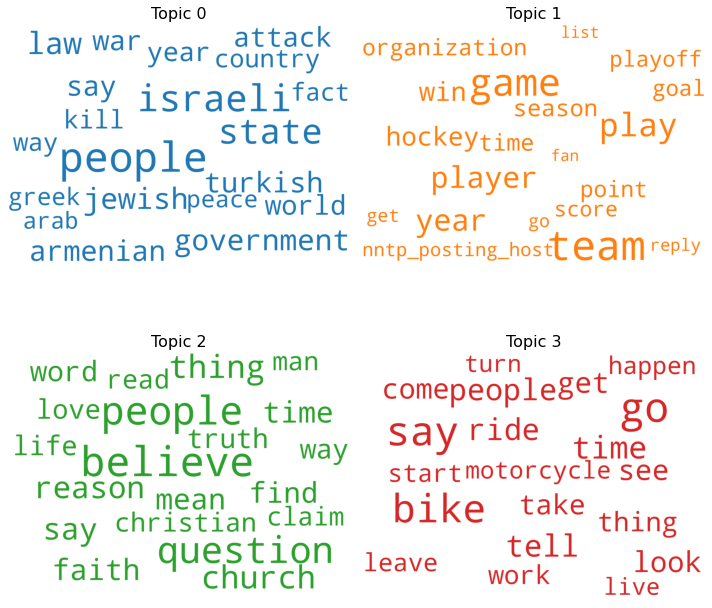

In [46]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=nlp.Defaults.stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_words=20)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

So with 400 iterations i was getting the same topic for "rec.motorcycles" and "rec.sport.hockey". I increased the number of iterations and num rounds and they got different topics. 

**Important:**

Please bear in mind, that topics can come up in random order, so a mapping between the original labels and LDA's topic numbers is non-trivial! **You have to observe the topics, and try to come up with a mapping / interpretation of them!!** 

(Naturally, in a "normal", unlabeled dataset this in itself is a question, since you do not know the topics upfront.)

In [51]:
# Assign numbers to the topics!

topic_to_label_mapping={
                        "rec.motorcycles": 3, 
                        "talk.politics.mideast": 0, 
                        "soc.religion.christian": 2, 
                        "rec.sport.hockey": 1
                        }

#Just put this line here to halt the notebook, so you don't skip this. Remove if done! 

### Sentence and word coloring by topic

Please observe the results!

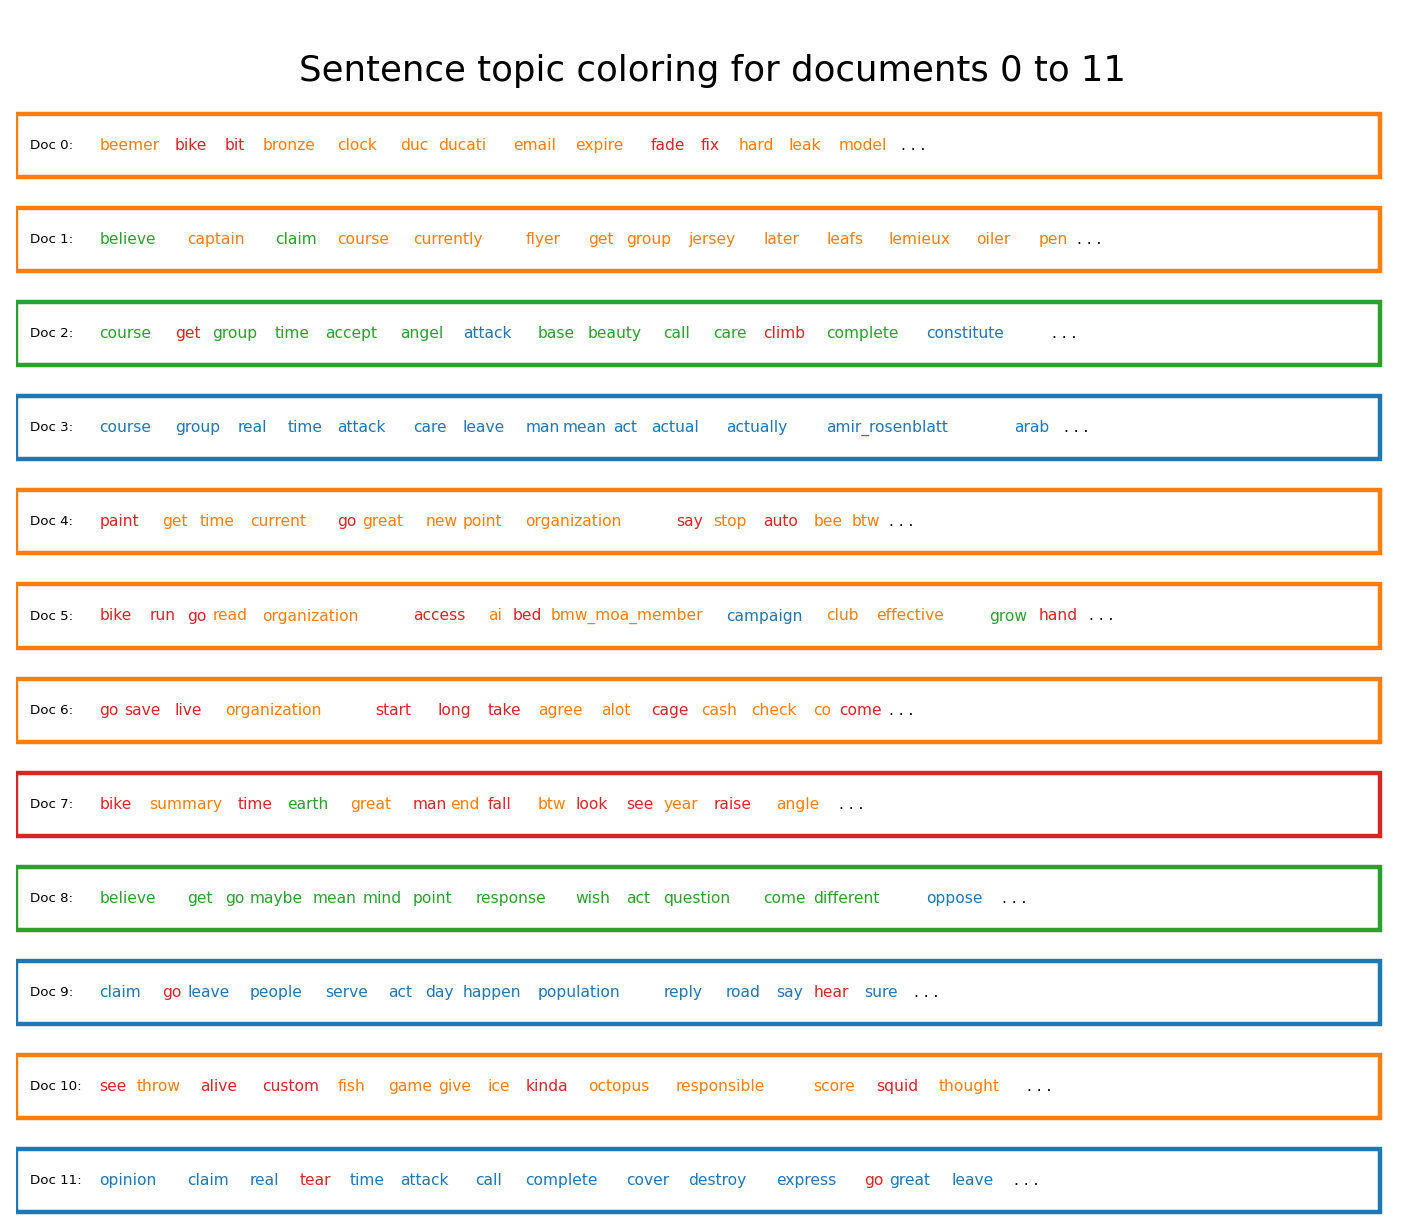

In [47]:
# Sentence Coloring of N Sentences
# For simplicity
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for _, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(9, (end-start)*0.6), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model.get_document_topics(corp_cur, per_word_topics=True)
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=6, color='black', transform=ax.transAxes, fontweight=300)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.98, 0.9, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=7, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=300)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=7, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence topic coloring for documents ' + str(start) + ' to ' + str(end-2), fontsize=16, y=0.95, fontweight=300)
    plt.tight_layout()
    plt.show()

sentences_chart()    

### t-SNE visualisation of the documents


In [73]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

topic_probs = []

# Get the topic probabilities for the whole corpus from the model
for probs in lda_model.get_document_topics(corpus, minimum_probability=-1): # minimum_probability=-1 to always get all probs
    topic_probs.append([prob for _, prob in probs])

# Topic probs df
df_topic_probs = pd.DataFrame(topic_probs, columns=["topic_0_prob", "topic_1_prob", "topic_2_prob", "topic_3_prob"])

# Topic weights NumPy array
arr = df_topic_probs.values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# Fit a tSNE model
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2361 samples in 0.002s...
[t-SNE] Computed neighbors for 2361 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2361
[t-SNE] Computed conditional probabilities for sample 2000 / 2361
[t-SNE] Computed conditional probabilities for sample 2361 / 2361
[t-SNE] Mean sigma: 0.028233
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.885551
[t-SNE] KL divergence after 1000 iterations: 0.633735


looks like two wings of a Butterfly. Docs are well seperated according to there respective topics. I can also notice that docs related Politics and Religion are part of the left wing of the "Butterfly" and motorcycles and sports/hockey other. I am not into politics or religion but i have heard that people tend to include religion into politics or vise versa. Secondly motorcycles and sports/hockey are also somewhat related to each other. 

### pyLDAvis
pyLDAvis is a nice off-the-shelve solution for visualising the found topics and keywords.

In [52]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
# Warning: "prepare" can take up to 5 minutes!
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.220500  0.114795       1        1  29.742247
2      0.125037 -0.226256       2        1  26.618385
3     -0.235238 -0.115957       3        1  23.558898
1     -0.110299  0.227417       4        1  20.080470, topic_info=         Term         Freq        Total Category  logprob  loglift
945      team  1033.000000  1033.000000  Default  30.0000  30.0000
524      game   884.000000   884.000000  Default  29.0000  29.0000
1        bike   711.000000   711.000000  Default  28.0000  28.0000
45       play   617.000000   617.000000  Default  27.0000  27.0000
30    believe   787.000000   787.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
53       time   308.300099  1324.876679   Topic4  -4.9284   0.1474
1600     well   163.004792   256.889701   Topic4  -5.5657   1.1506
85         go   234.014016  1178.385495   Topic4  -5.2041  -0.0111
86      great   175.218664   417.220638   Topic4  -5.4934   0.7378
112      post   165.658359   439.853454   Topic4  -5.5495   0.6289

[255 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2643      2  0.991339  absolute
1556      1  0.956838    action
1556      4  0.039399    action
1047      3  0.986555    advice
2782      3  0.993039    afraid
...     ...       ...       ...
378       4  0.102044     world
2863      2  0.989755   worship
255       1  0.315229      year
255       3  0.124822      year
255       4  0.559585      year

[359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

# The LDA model as a classifier

## Using simply the dominant topic as predicted class

First we extend our original dataframe with our "predictions" (the dominant topic) and the ground truth.

In [53]:
df["group_id"] = df.target_names.map(topic_to_label_mapping)
df["group_id_predicted"] = texts_topics_df.topic_no
df.head()

,index,content,target_names,group_id,group_id_predicted
0,10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,rec.motorcycles,3,1
1,21,From: leunggm@odin.control.utoronto.ca (Gary L...,rec.sport.hockey,1,1
2,28,From: jonh@david.wheaton.edu (Jonathan Hayward...,soc.religion.christian,2,2
3,33,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,talk.politics.mideast,0,0
4,35,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,rec.sport.hockey,1,1


Let's see how well we are doing...

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(df.group_id, df.group_id_predicted))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       564
           1       0.82      0.97      0.89       600
           2       0.88      0.86      0.87       599
           3       0.84      0.77      0.80       598

    accuracy                           0.85      2361
   macro avg       0.86      0.85      0.85      2361
weighted avg       0.86      0.85      0.85      2361



## Using topic probabilities for training a linear classifier

The topic probability distributions for documents provided by an LDA model can be useful feature vectors for document classification, e.g., for sentiment analysis. To illustrate this, we train an SVM classifier to predict the original topic of documents based on the LDA topic probabilities. First we add the whole topic distribution to our df.

In [55]:
df = pd.concat([df, df_topic_probs], axis = 1)
df.head()

,index,content,target_names,group_id,group_id_predicted,topic_0_prob,topic_1_prob,topic_2_prob,topic_3_prob
0,10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,rec.motorcycles,3,1,0.010005,0.631116,0.012896,0.345983
1,21,From: leunggm@odin.control.utoronto.ca (Gary L...,rec.sport.hockey,1,1,0.008781,0.823891,0.095814,0.071514
2,28,From: jonh@david.wheaton.edu (Jonathan Hayward...,soc.religion.christian,2,2,0.119157,0.003565,0.687157,0.190121
3,33,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,talk.politics.mideast,0,0,0.739599,0.003061,0.040468,0.216872
4,35,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,rec.sport.hockey,1,1,0.007461,0.717981,0.009095,0.265464


We do a train-test split:


In [56]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df, test_size=0.1)
print("df_train len:", len(df_train))
print("df_valid len:", len(df_valid))

df_train len: 2124
df_valid len: 237


And train an SVM classifier on the data

In [57]:
from sklearn.svm import SVC

svc = SVC(kernel="linear")

svc.fit(df_train[["topic_0_prob", "topic_1_prob", "topic_2_prob", "topic_3_prob"]], df_train.group_id)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [58]:
valid_predictions = svc.predict(df_valid[["topic_0_prob", "topic_1_prob", "topic_2_prob", "topic_3_prob"]])

print(classification_report(df_valid.group_id, valid_predictions))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90        59
           1       0.92      0.92      0.92        59
           2       0.93      0.86      0.90        50
           3       0.82      0.93      0.87        69

    accuracy                           0.89       237
   macro avg       0.90      0.89      0.90       237
weighted avg       0.90      0.89      0.90       237



Looking at the results we can see that we gained 6% accuracy by switching from using simply the dominant topic to an SVM classifier trained explicitly on the original topic/newsgroup labels.